In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# reuse library
def plotimage(title,img,colormap='gray'):
    print("title :",title)
    plotting = plt.imshow(img, cmap=colormap)
    plt.show()

def saveImage(name,image):
    path = '../image/box-extract'
    cv2.imwrite(path+'/'+name, image)
    print('----------save image success !!-------')

def sortContours(cnts, method='left-to-right'):

    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if (method == 'right-to-left' or method == 'bottom-to-top'):
        reverse = True
    
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if (method == 'top-to-bottom' or method == 'bottom-to-top'):
        i = 1
    
    # construct the list of bounding boxes and sort them from top to
    # bottom 
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][i], reverse=reverse))

    return (cnts, boundingBoxes)

def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized


title : paper ref for wraping


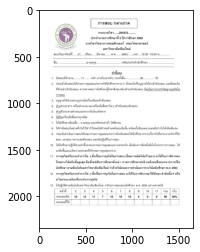

title : paper ref keypoint


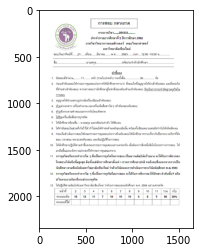

title : paper (user)


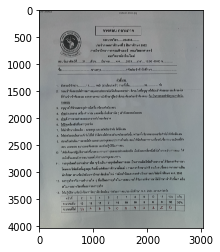

title : paper matching


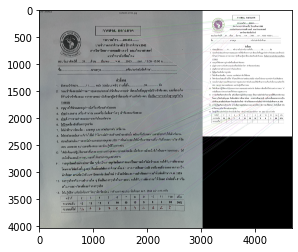

title : paper scan


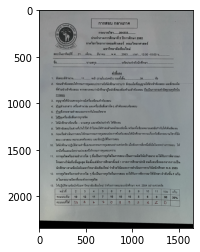

In [3]:
# wrap paper
# 1. detect image reference keypoint
# import image reference
paper_ref = cv2.imread('../image/midterm-score/midterm-score.jpg')

# --debug image ref
plotimage('paper ref for wraping', paper_ref)

# define num of feature only orb algo
orb = cv2.ORB_create(nfeatures=1000)

# find the feature of img ref
kp1, des1 = orb.detectAndCompute(paper_ref, None)

# --debug image ref keypoint
paper_kp1 = cv2.drawKeypoints(paper_ref, kp1, None)
plotimage('paper ref keypoint', paper_kp1)

# 2. mapping keypoint between img ref and img 
# import image (from user)
paper = cv2.imread('../image/userForms-image/test8.jpg')

# --debug img
plotimage('paper (user)', paper)

# find the feature of img user
kp2, des2 = orb.detectAndCompute(paper, None)

# Brute Force Matcher
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matches = bf.match(des2, des1)

# --debug matches
persen = 5
matches.sort(key = lambda x:x.distance)
good = matches[:int(len(matches) * (persen/100))]
paperMatches = cv2.drawMatches(paper, kp2, paper_ref, kp1, good, None, flags=2)
plotimage('paper matching',paperMatches)

# 3. scan and wrapping 
srcPts = np.float32([kp2[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dstPts = np.float32([kp1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
M, _ = cv2.findHomography(srcPts, dstPts, cv2.RANSAC, 5.0)
h, w = paper_ref.shape[:2]
paper_scan = cv2.warpPerspective(paper, M, (w, h))

# --debug img scaning
plotimage('paper scan', paper_scan)

paper scan shape height, width, channel : 2339, 1654
title : paper roi


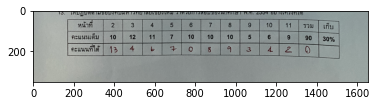

In [4]:
# define region of interesing of scanning paper

# x , y (position of x , y) , c (channel)
y_paper, x_paper, c_paper = paper_scan.shape

# --debug paper scan shape
print('paper scan shape height, width, channel : {}, {}'.format(y_paper, x_paper, c_paper))

# find interesing region
y_start, y_end = y_paper - int(y_paper*0.2) , y_paper - int(y_paper*0.05)
paper_roi = paper_scan[y_start:y_end,:]

# --debug paper roi
plotimage('paper roi', paper_roi)

title : gray image


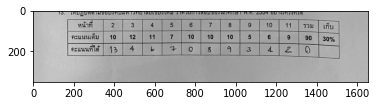

title : blur image


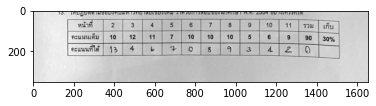

title : thresholding image


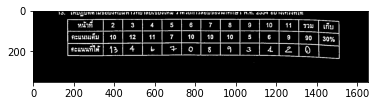

length of kernel :  16
title : image vertical line


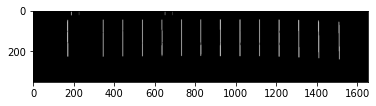

title : image horizontal line


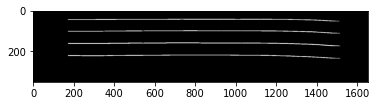

title : image vertical and horizontail (img_vh)


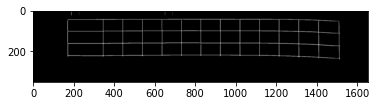

title : thresholding and eroding image (img_vh erode)


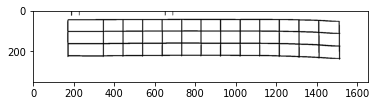

title : bit nor


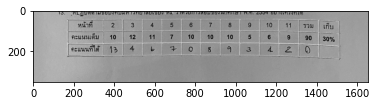

In [5]:
# line segmentation

# 1. preparing image
# image convertion (RGB --> Grayscale)
gray_img = cv2.cvtColor(paper_roi, cv2.COLOR_BGR2GRAY)

# --debug gray image
plotimage('gray image', gray_img)

# Guassian blur
blur = cv2.GaussianBlur(gray_img,(5,5),0)

# --debug G blur
plotimage('blur image', blur)

# adaptive thresholding
thresh = cv2.adaptiveThreshold(blur,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,35,10)

# --debug thresh
plotimage('thresholding image', thresh)

# 2. segmentation
# define 3 kernel (kernel, vertical kernel, horizontail kernel)
kernel_len = np.array(paper_roi).shape[1] // 100
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))

# --debug length of kernel
print('length of kernel : ',kernel_len)

# vertical kernel to detect line in paper
erode_ver = cv2.erode(thresh, ver_kernel, iterations=3)
dilate_ver = cv2.dilate(erode_ver, ver_kernel, iterations=3)

# --debug ver image
plotimage('image vertical line', dilate_ver)

# horizontail kernel to detect line in paper
erode_hor = cv2.erode(thresh, hor_kernel, iterations=3)
dilate_hor = cv2.dilate(erode_hor, hor_kernel, iterations=3)

# --debug hor image
plotimage('image horizontal line', dilate_hor)

# combine ver and hor
img_vh = cv2.addWeighted(dilate_ver, 0.5, dilate_hor, 0.5, 0.0)

# --debug ver and her image
plotimage('image vertical and horizontail (img_vh)', img_vh)

# eroding and thresholding in image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh_vh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

# --debug thresholding and eroding image
plotimage('thresholding and eroding image (img_vh erode)',img_vh)

# combine gray img and img_vh using bitwise
bitxor = cv2.bitwise_xor(gray_img,img_vh)
bitnot = cv2.bitwise_not(bitxor)

# --debug bitwise 
plotimage('bit nor', bitnot)

title : draw contours


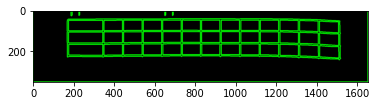

In [6]:
# table detection using contours

# contours image 
contours, _ = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# sorting contours
contours, boundingBoxes = sortContours(contours, method='top-to-bottom')

# --debug draw contours
mask = np.zeros(paper_roi.shape, dtype=np.uint8)
cv2.drawContours(mask, contours, -1, (0, 255, 0), 3)
plotimage('draw contours', mask)


---------------------------------------------------------------------
title : box 2


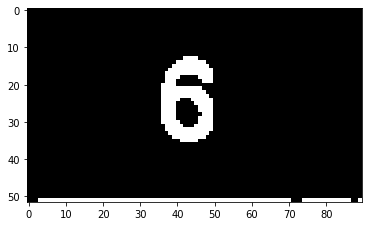

b (width, height) : (14,23)
title : (width, height) predict 8: (28,28)


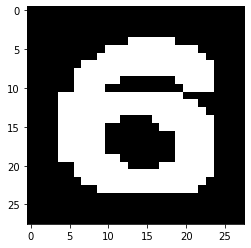

---------------------------------------------------------------------
title : box 3


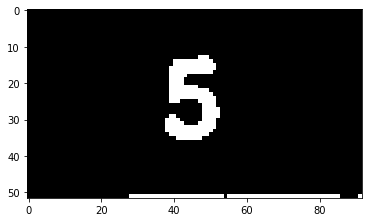

b (width, height) : (15,23)
title : (width, height) predict 5: (28,28)


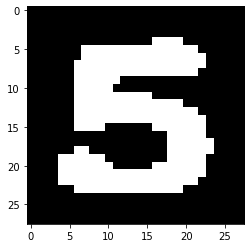

---------------------------------------------------------------------
title : box 4


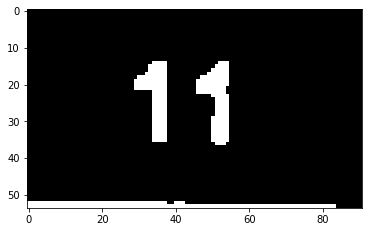

b (width, height) : (9,23)
title : (width, height) predict 7: (28,28)


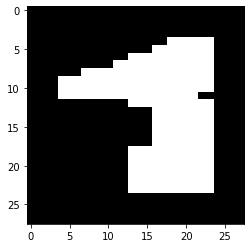

b (width, height) : (9,22)
title : (width, height) predict 7: (28,28)


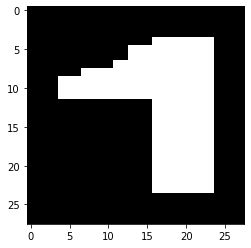

---------------------------------------------------------------------
title : box 5


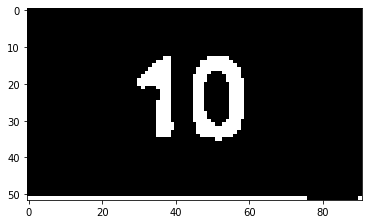

b (width, height) : (14,23)
title : (width, height) predict 0: (28,28)


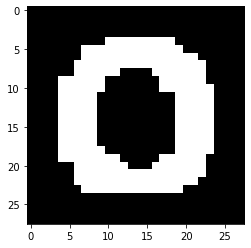

b (width, height) : (10,22)
title : (width, height) predict 2: (28,28)


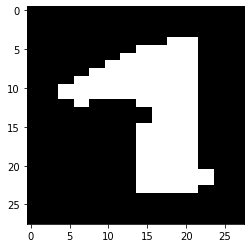

---------------------------------------------------------------------
title : box 6


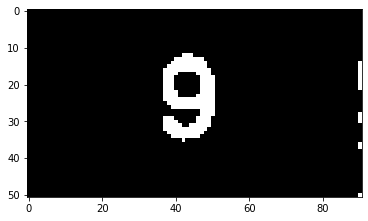

b (width, height) : (14,24)
title : (width, height) predict 8: (28,28)


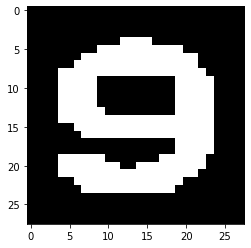

---------------------------------------------------------------------
title : box 7


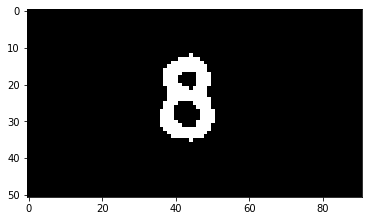

b (width, height) : (15,24)
title : (width, height) predict 8: (28,28)


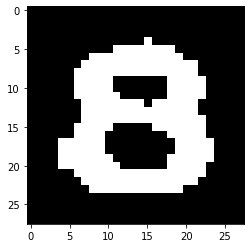

---------------------------------------------------------------------
title : box 8


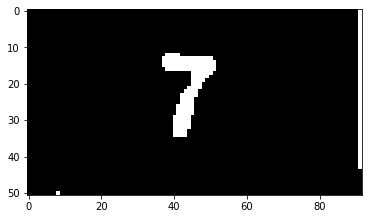

b (width, height) : (15,23)
title : (width, height) predict 3: (28,28)


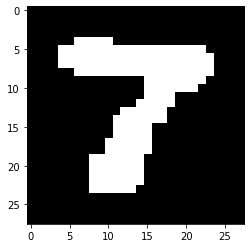

---------------------------------------------------------------------
title : box 9


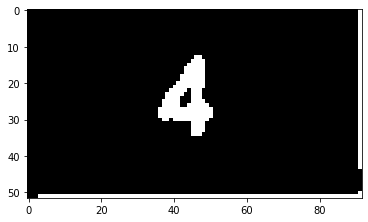

b (width, height) : (15,22)
title : (width, height) predict 4: (28,28)


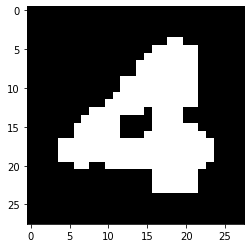

---------------------------------------------------------------------
title : box 10


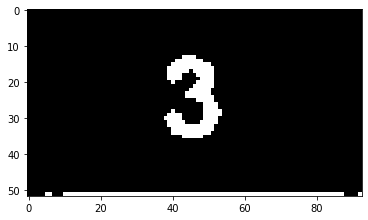

b (width, height) : (16,23)
title : (width, height) predict 3: (28,28)


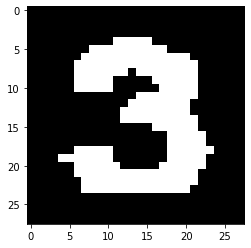

---------------------------------------------------------------------
title : box 11


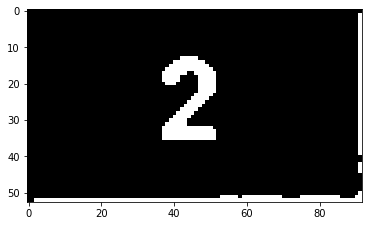

b (width, height) : (15,23)
title : (width, height) predict 2: (28,28)


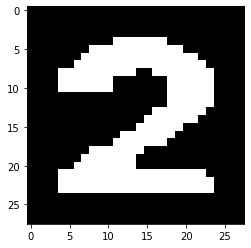

---------------------------------------------------------------------
title : box 12


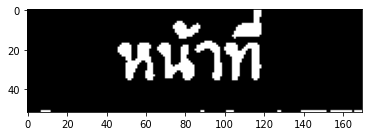

b (width, height) : (14,20)
title : (width, height) predict 2: (28,28)


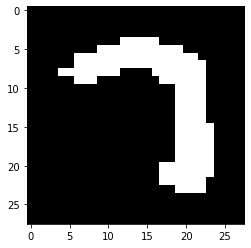

---------------------------------------------------------------------
title : box 13


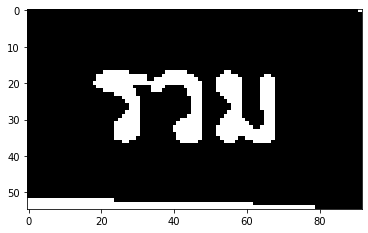

b (width, height) : (16,20)
title : (width, height) predict 0: (28,28)


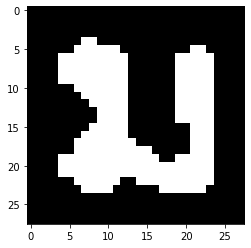

b (width, height) : (30,20)
title : (width, height) predict 8: (28,28)


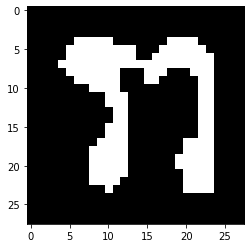

---------------------------------------------------------------------
title : box 14


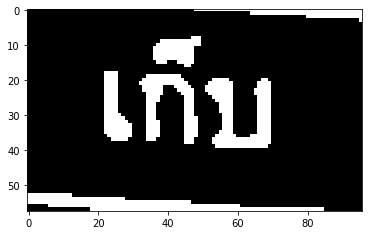

b (width, height) : (8,20)
title : (width, height) predict 2: (28,28)


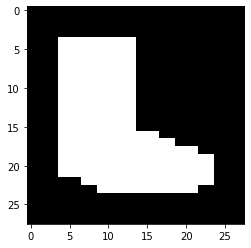

b (width, height) : (17,20)
title : (width, height) predict 0: (28,28)


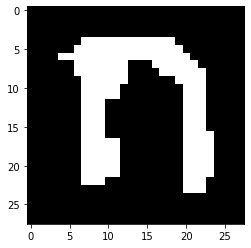

b (width, height) : (19,20)
title : (width, height) predict 0: (28,28)


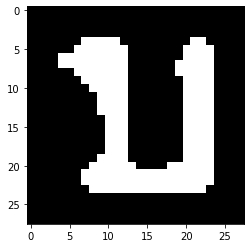

---------------------------------------------------------------------
title : box 15


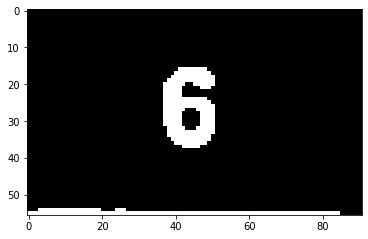

b (width, height) : (14,22)
title : (width, height) predict 6: (28,28)


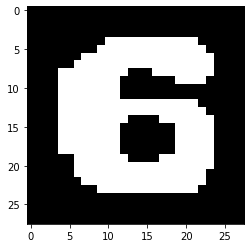

---------------------------------------------------------------------
title : box 16


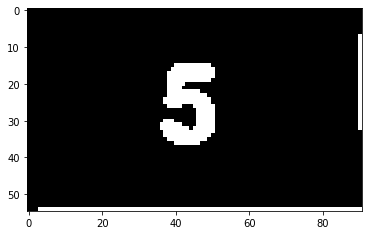

b (width, height) : (15,22)
title : (width, height) predict 5: (28,28)


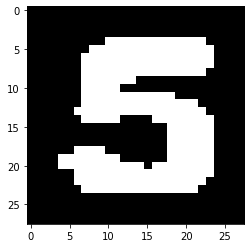

---------------------------------------------------------------------
title : box 17


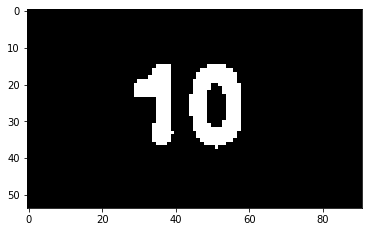

b (width, height) : (14,23)
title : (width, height) predict 0: (28,28)


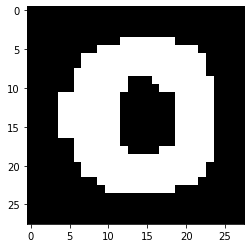

b (width, height) : (11,22)
title : (width, height) predict 7: (28,28)


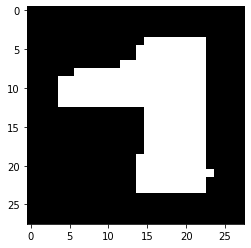

---------------------------------------------------------------------
title : box 18


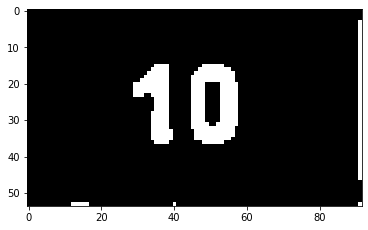

b (width, height) : (13,22)
title : (width, height) predict 0: (28,28)


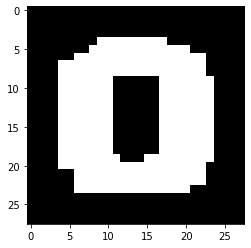

b (width, height) : (11,22)
title : (width, height) predict 7: (28,28)


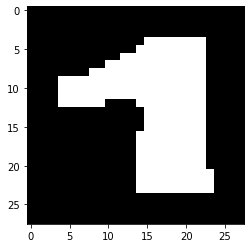

---------------------------------------------------------------------
title : box 19


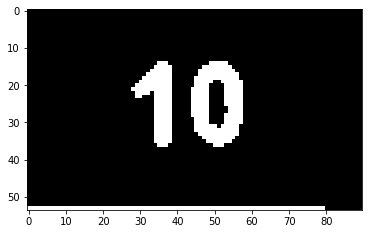

b (width, height) : (14,23)
title : (width, height) predict 0: (28,28)


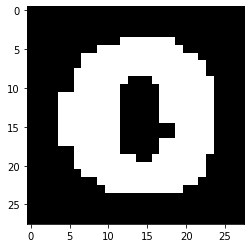

b (width, height) : (11,23)
title : (width, height) predict 7: (28,28)


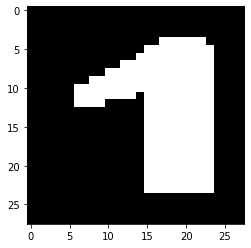

---------------------------------------------------------------------
title : box 20


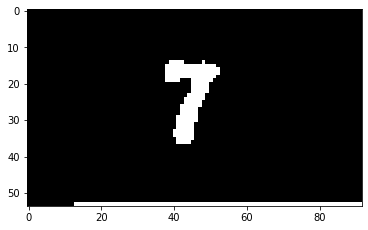

b (width, height) : (15,23)
title : (width, height) predict 3: (28,28)


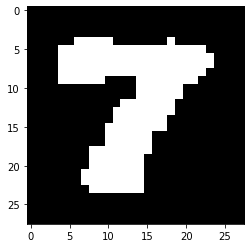

---------------------------------------------------------------------
title : box 21


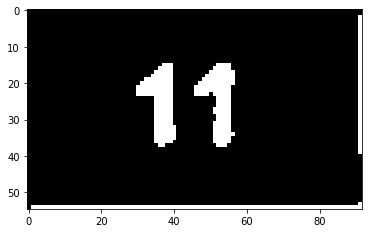

b (width, height) : (11,23)
title : (width, height) predict 7: (28,28)


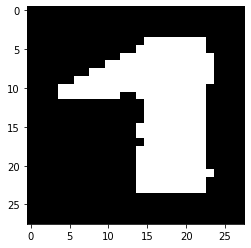

b (width, height) : (11,23)
title : (width, height) predict 7: (28,28)


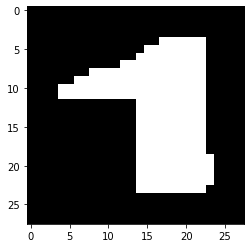

---------------------------------------------------------------------
title : box 22


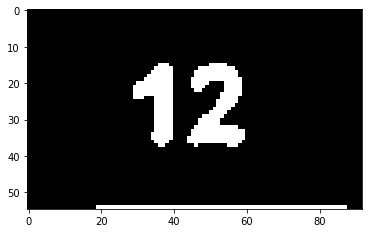

b (width, height) : (16,23)
title : (width, height) predict 2: (28,28)


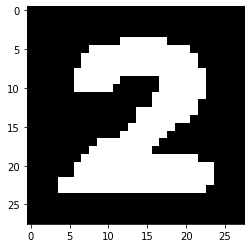

b (width, height) : (11,23)
title : (width, height) predict 7: (28,28)


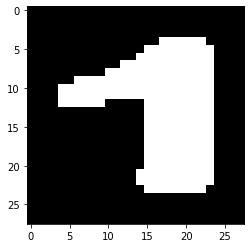

---------------------------------------------------------------------
title : box 23


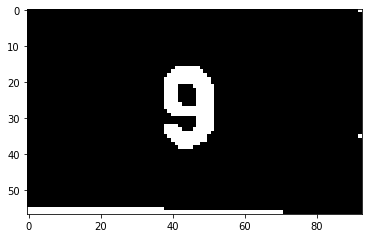

b (width, height) : (14,23)
title : (width, height) predict 8: (28,28)


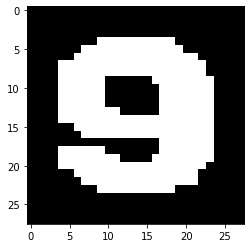

---------------------------------------------------------------------
title : box 24


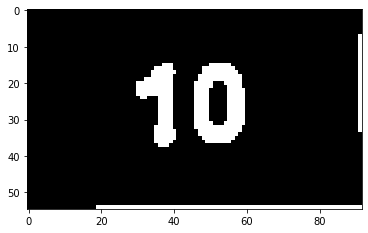

b (width, height) : (14,22)
title : (width, height) predict 0: (28,28)


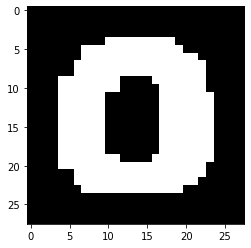

b (width, height) : (11,23)
title : (width, height) predict 7: (28,28)


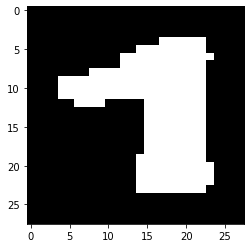

---------------------------------------------------------------------
title : box 25


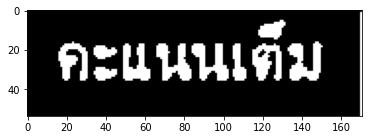

b (width, height) : (18,20)
title : (width, height) predict 0: (28,28)


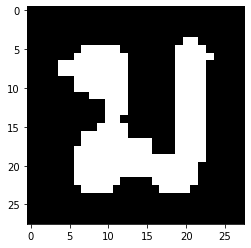

b (width, height) : (15,20)
title : (width, height) predict 8: (28,28)


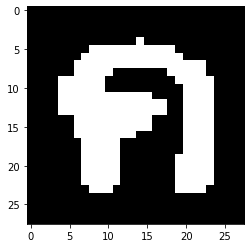

---------------------------------------------------------------------
title : box 26


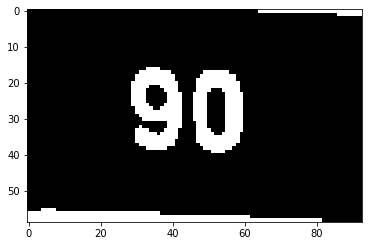

b (width, height) : (14,23)
title : (width, height) predict 8: (28,28)


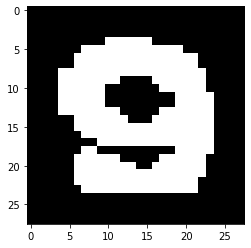

b (width, height) : (14,23)
title : (width, height) predict 0: (28,28)


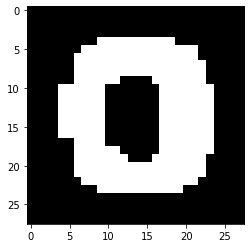

---------------------------------------------------------------------
title : box 27


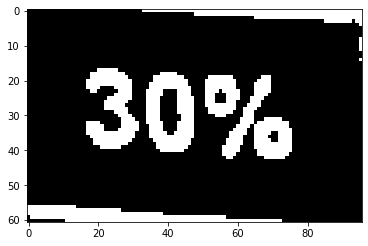

b (width, height) : (15,23)
title : (width, height) predict 3: (28,28)


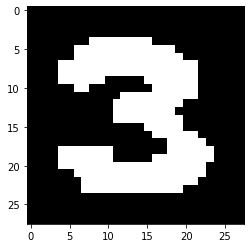

b (width, height) : (14,23)
title : (width, height) predict 0: (28,28)


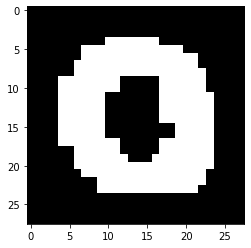

b (width, height) : (20,24)
title : (width, height) predict 6: (28,28)


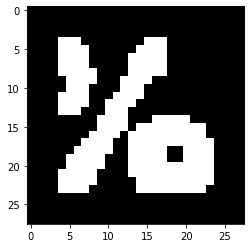

---------------------------------------------------------------------
title : box 28


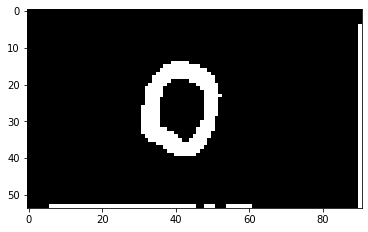

b (width, height) : (22,26)
title : (width, height) predict 0: (28,28)


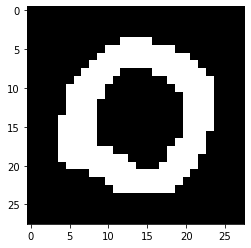

---------------------------------------------------------------------
title : box 29


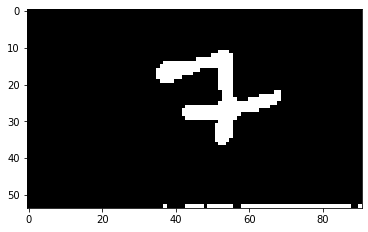

b (width, height) : (34,26)
title : (width, height) predict 7: (28,28)


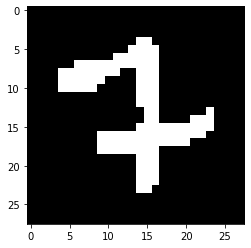

---------------------------------------------------------------------
title : box 30


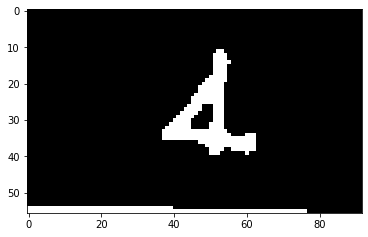

b (width, height) : (26,29)
title : (width, height) predict 2: (28,28)


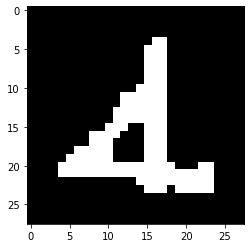

---------------------------------------------------------------------
title : box 31


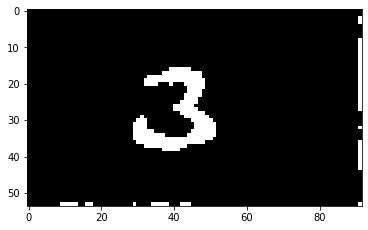

b (width, height) : (23,23)
title : (width, height) predict 3: (28,28)


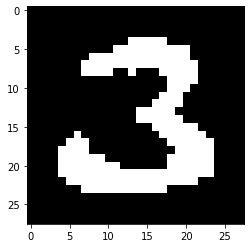

---------------------------------------------------------------------
title : box 32


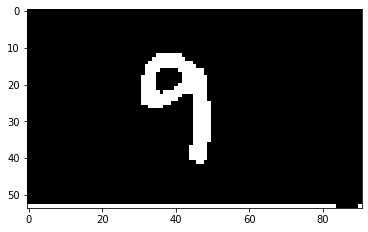

b (width, height) : (19,30)
title : (width, height) predict 9: (28,28)


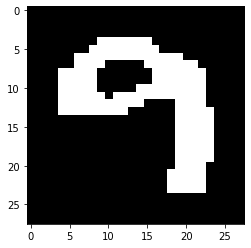

---------------------------------------------------------------------
title : box 33


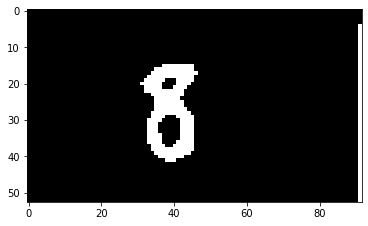

b (width, height) : (16,27)
title : (width, height) predict 8: (28,28)


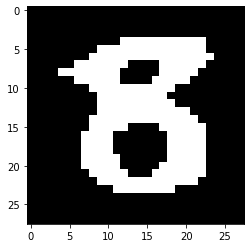

---------------------------------------------------------------------
title : box 34


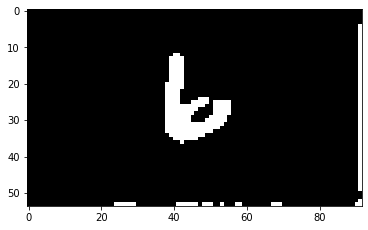

b (width, height) : (18,25)
title : (width, height) predict 6: (28,28)


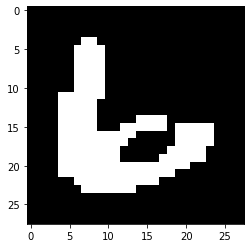

---------------------------------------------------------------------
title : box 35


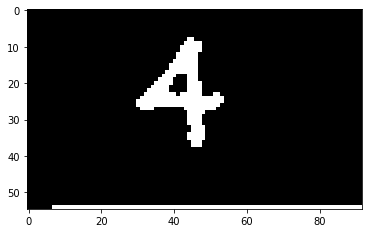

b (width, height) : (24,30)
title : (width, height) predict 4: (28,28)


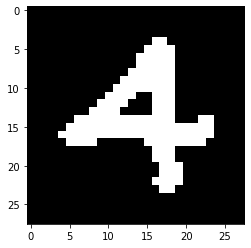

---------------------------------------------------------------------
title : box 36


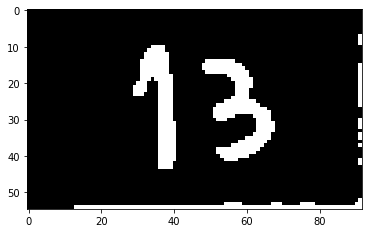

b (width, height) : (12,34)
title : (width, height) predict 7: (28,28)


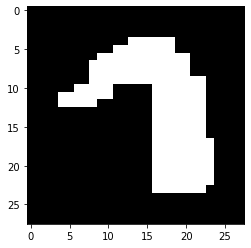

b (width, height) : (20,28)
title : (width, height) predict 3: (28,28)


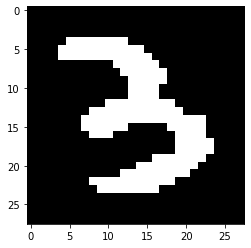

---------------------------------------------------------------------
title : box 37


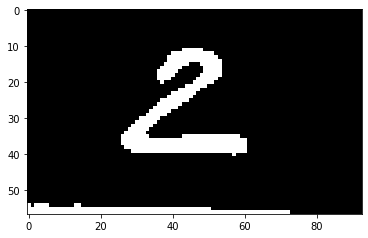

b (width, height) : (35,30)
title : (width, height) predict 2: (28,28)


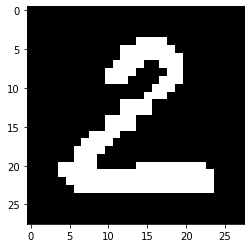

---------------------------------------------------------------------
title : box 38


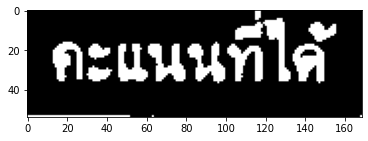

b (width, height) : (28,32)
title : (width, height) predict 0: (28,28)


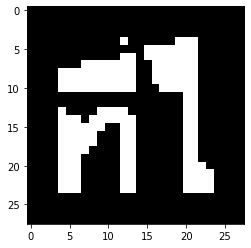

b (width, height) : (19,21)
title : (width, height) predict 1: (28,28)


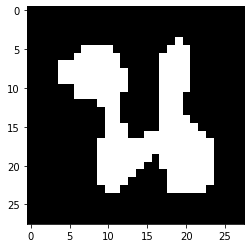

b (width, height) : (15,20)
title : (width, height) predict 0: (28,28)


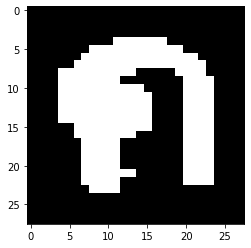

b (width, height) : (16,20)
title : (width, height) predict 8: (28,28)


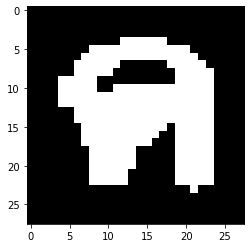

---------------------------------------------------------------------
title : box 39


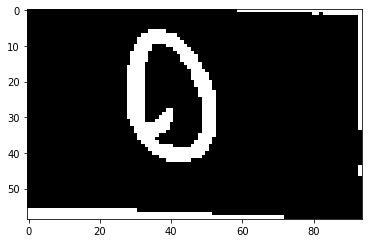

b (width, height) : (35,34)
title : (width, height) predict 5: (28,28)


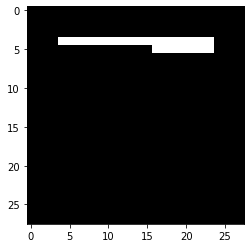

b (width, height) : (25,37)
title : (width, height) predict 0: (28,28)


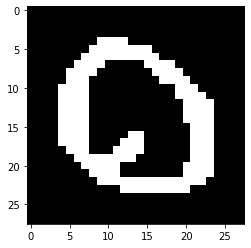

b (width, height) : (18,31)
title : (width, height) predict 2: (28,28)


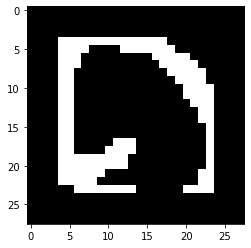

---------------------------------------------------------------------
title : box 40


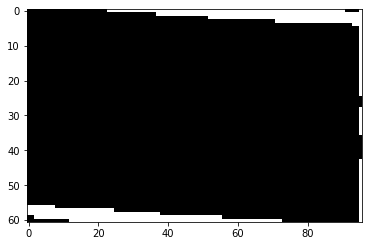

---------------------------------------------------------------------


In [24]:
# load model
from keras.models import load_model
model = load_model('/Users/sutimarpengpinij/Desktop/204491_Independence/handwritten-recognize-491/model/model_02_MNIST.h5')

# table extraction

# loop in box of table
count = 0
height_lists = []

for i in range(len(contours)):
    x, y, w, h = cv2.boundingRect(contours[i])

    if(i != 0):

        count += 1
        height_lists.append(h)

        box = thresh[y:y+h, x:x+w]

        contours_box, _ = cv2.findContours(box, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        contours_box, boundingBoxes = sortContours(contours_box, method='top-to-bottom')

        if(i != 1):

            plotimage('box '+str(i), box)

            for cb in contours_box:
                x2, y2, w2, h2 = cv2.boundingRect(cb)

                if(h2 > 19 and h2 < 41 and w2 > 7 and w2 < 41):
                    b = box[y2:y2+h2, x2:x2+w2]
                    
                    print("b (width, height) : ({},{})".format(b.shape[1], b.shape[0]))
                    
                    b = cv2.resize(b, (20,20), interpolation=cv2.INTER_NEAREST)
                    b = np.pad(b, [( 4, 4 )], "constant", constant_values=0)
                    
                    predicts = model.predict(b.reshape(1,28,28,1))
                    ans = np.argmax(predicts)
                    
                    s = "(width, height) predict {}: ({},{})".format(ans,b.shape[1], b.shape[0])
                    plotimage(s,b)

        
        print("---------------------------------------------------------------------")

        #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2,2))
         

        # --debug box info
        # plotimage('box '+str(i), box)
        # print("pixel (x,y): ({},{})".format(x,y))
        # print("width : {} , height : {}".format(w,h))
        # print("-------------------------------------------")


    